In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler,PolynomialFeatures


In [92]:
X_train_1 =pd.read_csv("../data/X_train_part1.csv", index_col = "index")
X_train_2 =pd.read_csv("../data/X_train_part2.csv", index_col = "index")
X_train_3 =pd.read_csv("../data/X_train_part3.csv", index_col = "index")
X_train = pd.concat([X_train_1,X_train_2,X_train_3])
y_train = pd.read_csv("../data/y_train.csv", index_col = "index")

X_test =pd.read_csv("../data/X_test.csv", index_col = "index")
y_test = pd.read_csv("../data/y_test.csv", index_col = "index")

# 1. Linear Regression

## 1.1 Modelling

In [93]:
# we are not using month for the linear model
X_train_LR = X_train.drop(columns=["month"])
X_test_LR = X_test.drop(columns=["month"])

In [94]:
# Initialize the linear regression model
linear_model = LinearRegression()

# Fit the model to the training data
linear_model.fit(X_train_LR, y_train)

LinearRegression()

In [95]:
features = linear_model.feature_names_in_
coefficient = linear_model.coef_
flattened_coefficients = coefficient.flatten()


coefficients_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': flattened_coefficients
})

print(coefficients_df)

            Feature   Coefficient
0         flat_type  38438.033531
1    floor_area_sqm   2807.396860
2   remaining_lease  -4000.456182
3      lower_storey -49175.434035
4      upper_storey  57166.448817
5       region_East -38158.206762
6      region_North -47352.668384
7  region_Northeast   3513.179014
8       region_West -51324.707780


## 1.2 Evaluation

In [96]:
# Make predictions on the training set
y_train_pred_LR = linear_model.predict(X_train_LR)

# Calculate training performance metrics
train_rmse = root_mean_squared_error(y_train, y_train_pred_LR)
train_r2 = r2_score(y_train, y_train_pred_LR)

print(f"Training RMSE: {train_rmse}")
print(f"Training R2 Score: {train_r2}")

Training RMSE: 127469.33314519392
Training R2 Score: 0.4563263511597717


The R2 score of training set is rather low of only 0.4563, meaning that only 45.63% of the variance is explained by the model.

In addition, the RMSE value is very high, indicating a high bias.

In [97]:
# Make predictions on the test set
y_test_pred_LR = linear_model.predict(X_test_LR)

# Calculate test performance metrics
test_rmse = root_mean_squared_error(y_test, y_test_pred_LR)
test_r2 = r2_score(y_test, y_test_pred_LR)

print(f"Test RMSE: {test_rmse}")
print(f"Test R2 Score: {test_r2}")

Test RMSE: 127582.42658945534
Test R2 Score: 0.45764370745644933


Although the R2 score and RMSE of the test set did not differ much from the train set, meaning that there is no overfitting, the poor performance persist.

## 1.3 Checking for feature-target relationship

We want to examine if there is non-linear relationship between the feature and the target. If exist, we may conduct transformation to the feature.

### 1.3.1 Numerical

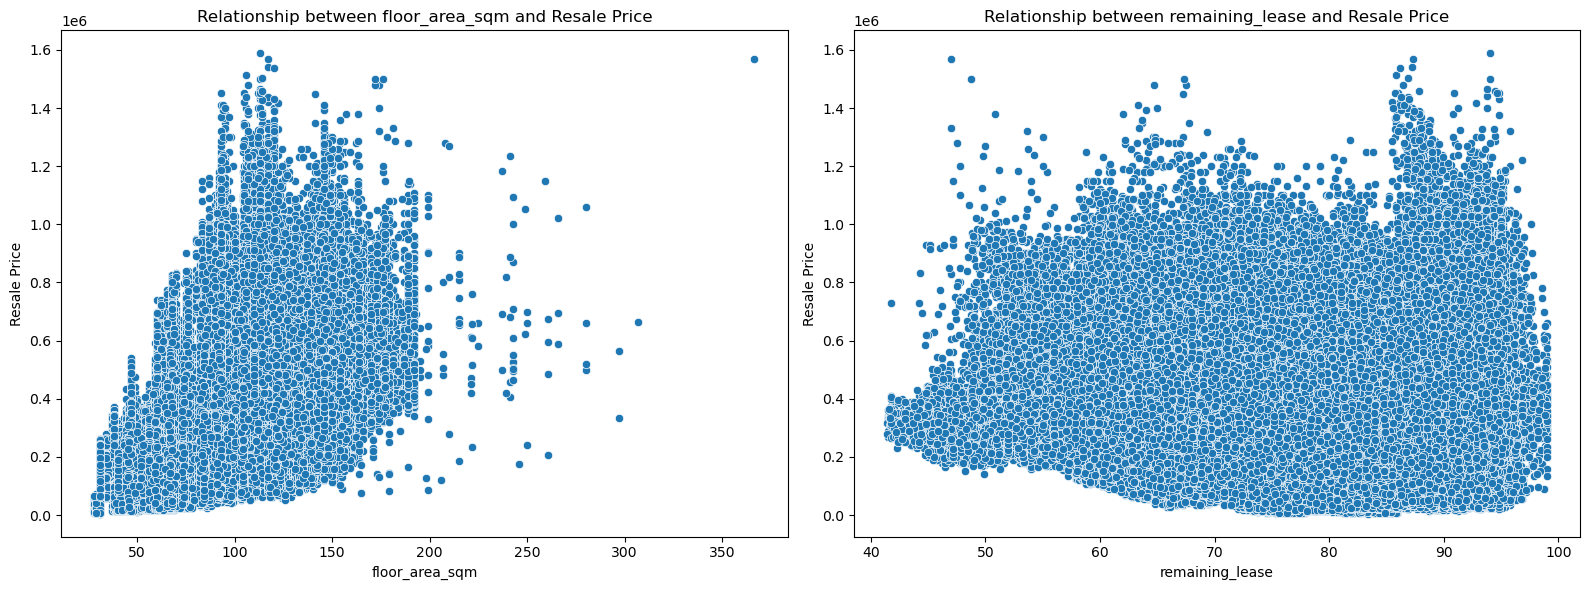

In [98]:
numerical_features = ['floor_area_sqm', 'remaining_lease']
y_train_1d = y_train.squeeze()  

fig, axes = plt.subplots(1, 2, figsize=(16, 6))  

for ax, feature in zip(axes, numerical_features):
    sns.scatterplot(data=X_train, x=feature, y=y_train_1d, ax=ax)
    ax.set_title(f'Relationship between {feature} and Resale Price')
    ax.set_xlabel(feature)
    ax.set_ylabel('Resale Price')

plt.tight_layout()
plt.show()

`floor_area_sqm`:
- There seems to be a slight positive relationship (as floor area increases, resale price tends to increase).
- However, there is significant variability in prices for larger floor areas, especially above ~150 sqm.
- This might indicate diminishing returns (e.g., larger units don’t always translate to proportionally higher prices).
- May try log transformation which is more common for diminishing result.

`remaining_lease`:
- The relationship appears flat, with no obvious trend.
- Resale prices remain scattered across different lease durations, suggesting that remaining_lease alone may not strongly influence price.

## 1.4 Residual analysis

We wish to further examing the relationship between the features and the target by looking at its residuals

### `floor_area_sqm`

This feature is chosen as we suspect that there may be some pattern from the previous analysis.

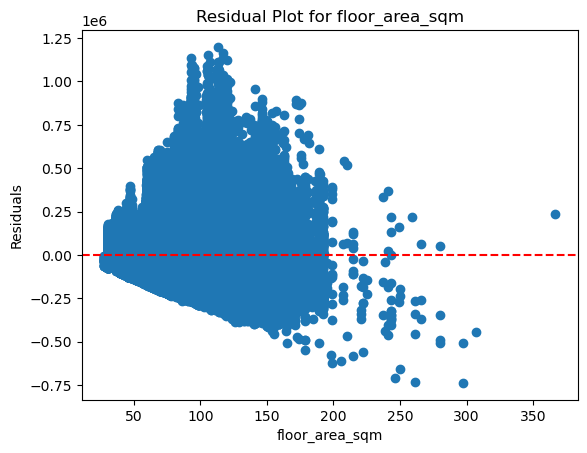

In [101]:
feature = 'floor_area_sqm'
model = LinearRegression()


model.fit(X_train_LR[[feature]], y_train)
y_pred = model.predict(X_train_LR[[feature]])


residuals = y_train - y_pred

# Plot residuals
plt.scatter(X_train_LR[feature], residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title(f'Residual Plot for {feature}')
plt.xlabel(feature)
plt.ylabel('Residuals')
plt.show()

The residual is not randomly scattered around the red-horizontal line. The variance of the error is not constant(heteroscedastic). We will try to apply log-transformation to see if it improves the result. 

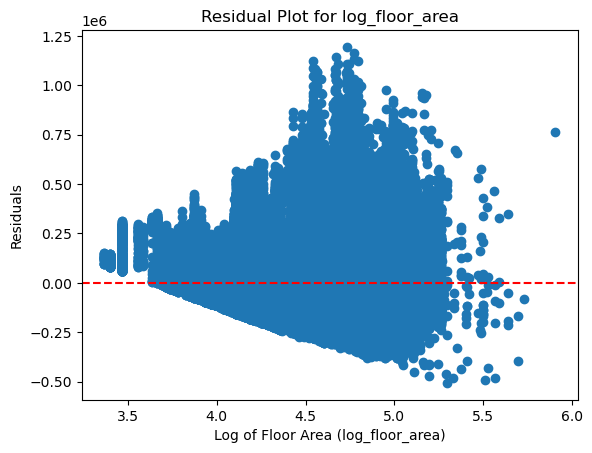

In [102]:
X_train_log_transformed = X_train.copy()
X_train_log_transformed['log_floor_area'] = np.log1p(X_train['floor_area_sqm'])

model = LinearRegression()
model.fit(X_train_log_transformed[['log_floor_area']], y_train)

y_pred = model.predict(X_train_log_transformed[['log_floor_area']])
residuals = y_train - y_pred

# Plot residuals
plt.scatter(X_train_log_transformed['log_floor_area'], residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot for log_floor_area')
plt.xlabel('Log of Floor Area (log_floor_area)')
plt.ylabel('Residuals')
plt.show()

The log transformation reduced some issues (e.g., narrowing the residual spread), but the relationship still doesn’t appear completely linear. The improvement suggests that the log transformation captures part of the diminishing returns, but it may not fully resolve the nonlinearity.

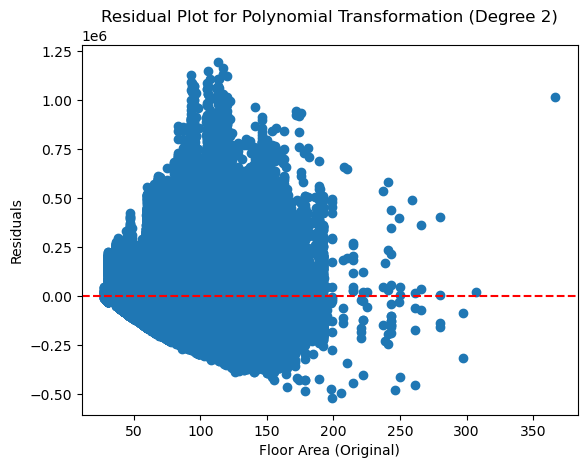

In [106]:
# Apply polynomial transformation (degree 2)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly_transformed = poly.fit_transform(X_train[['floor_area_sqm']])

# Fit the model
model = LinearRegression()
model.fit(X_train_poly_transformed, y_train)

# Predict and calculate residuals
y_pred = model.predict(X_train_poly_transformed)
residuals = y_train - y_pred

# Plot residuals against the original feature
plt.scatter(X_train['floor_area_sqm'], residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot for Polynomial Transformation (Degree 2)')
plt.xlabel('Floor Area (Original)')
plt.ylabel('Residuals')
plt.show()

# 3. Step-wise Regression

From the above analysis, some features may not contribute significantly to the predictive power of the model due to the violation of assumption(Linearity, homoscedasticity). To address this, we will use a stepwise regression method to identify the best set of predictors, ensuring that only relevant features are included in the model.